In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import tqdm
from transformers import get_linear_schedule_with_warmup

from UNet import UNet

### Hyper-parameters

In [2]:
# training
batch_size = 128
eval_batch_size = 256
learning_rate = 5e-5
num_epochs = 10
num_warmup_stesp = 500

# diffusion model
diffusion_steps = 1000
beta_large = 0.02
beta_small = 1e-4

### Setup

In [3]:
train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('/tmp/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                             ])),
      batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
     torchvision.datasets.MNIST('/tmp/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                             ])),
      batch_size=eval_batch_size, shuffle=True)

In [4]:
# model
model = UNet(
        input_channels=1,
        input_height=32,
        ch=64,
        ch_mult=(1, 2, 2, 2),
        num_res_blocks=1,
        attn_resolutions=(16,),
        resamp_with_conv=True,
        dropout=0.,
        )

### Tests Model and DataLoader

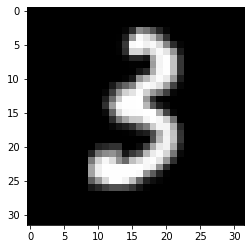

In [5]:
for batch in train_loader:
    break
    
fig = plt.figure
plt.imshow(batch[0][0].view(32,32), cmap='gray')
plt.show()

In [6]:
x_ = torch.randn(1, 1, 32, 32)
t = torch.zeros(1)
output = model(x_, t)
output.shape

torch.Size([1, 1, 32, 32])

In [7]:
# number of parameters
sum(p.numel() for p in model.parameters()) // 1e6

6.0

### Training

In [8]:
def add_noise(imgs):
    z_noise = torch.randn_like(imgs)
    ts = torch.randint(1, diffusion_steps, (imgs.shape[0],), device=imgs.device)
    a_sampled = alpha_bars[ts -1].view(-1, 1, 1, 1)
    noised_imgs = torch.sqrt(a_sampled) * imgs + torch.sqrt(1 - a_sampled) * z_noise
    return noised_imgs, ts, z_noise

In [9]:
# coefficietns
betas = torch.Tensor([beta_small + (t / diffusion_steps) * (beta_large - beta_small) for t in range(diffusion_steps)])
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, 0)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_stesp, num_training_steps=len(train_loader)*num_epochs)

In [11]:
# send to device
device = torch.device("cuda")
model = model.to(device)
betas = betas.to(device)
alphas = alphas.to(device)
alpha_bars = alpha_bars.to(device)

In [12]:
for epoch in range(num_epochs):
    
    model.train()
    pbar = tqdm.auto.tqdm(train_loader)
    for batch in pbar:
        imgs, labels = batch
        imgs = imgs.to(device)
        
        noised_imgs, ts, z_noise = add_noise(imgs)
        
        e_hat = model(noised_imgs, ts)
        
        loss = (e_hat - z_noise).square().mean()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        pbar.set_postfix({'loss': loss.item()})
        
    with torch.no_grad():
        model.eval()
        with torch.random.fork_rng():
            torch.random.manual_seed(123)
            loss = 0
            for batch in tqdm.auto.tqdm(test_loader):
                imgs, labels = batch
                imgs = imgs.to(device)

                noised_imgs, ts, z_noise = add_noise(imgs)

                e_hat = model(noised_imgs, ts)

                loss += (e_hat - z_noise).square().mean()

            loss /= len(test_loader)
            print(f"Epoch {epoch} Validation loss: {loss}")

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0 Validation loss: 0.6288435459136963


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
e_hat.shape

In [ ]:
z_noise.shape

In [ ]:
ts.size()

In [ ]:
from UNet import get_sinusoidal_positional_embedding

In [ ]:
get_sinusoidal_positional_embedding(torch.LongTensor([0, 1, 2, 3, 4]), 768)

In [ ]:
len(ts.size())

In [ ]:
def generate_cosine_schedule(T, s=0.008):
    def f(t, T):
        return (np.cos((t / T + s) / (1 + s) * np.pi / 2)) ** 2
    
    alphas = []
    f0 = f(0, T)

    for t in range(T + 1):
        alphas.append(f(t, T) / f0)
    
    betas = []

    for t in range(1, T + 1):
        betas.append(min(1 - alphas[t] / alphas[t - 1], 0.999))
    
    return np.array(betas)

In [ ]:
batch[0].shape

In [ ]:
"""
Corresponds to Algorithm 1 from (Ho et al., 2020).
"""
ts = torch.randint(0, self.t_range, [batch.shape[0]], device=self.device)
noise_imgs = []
epsilons = torch.randn(batch.shape, device=self.device)
for i in range(len(ts)):
    a_hat = self.alpha_bar(ts[i])
    noise_imgs.append(
        (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
    )
noise_imgs = torch.stack(noise_imgs, dim=0)
e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float))
loss = nn.functional.mse_loss(
    e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
)

In [ ]:
# Process samples and save as gif
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)

gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)

imageio.mimsave(
    f"{trainer.logger.log_dir}/pred.gif",
    list(gen_samples),
    fps=5,
)